### Loaded Packages

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import os
from sklearn.metrics import mean_squared_error
from math import sqrt
import random


from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.vector_ar.vecm import coint_johansen

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

### Data Exploration

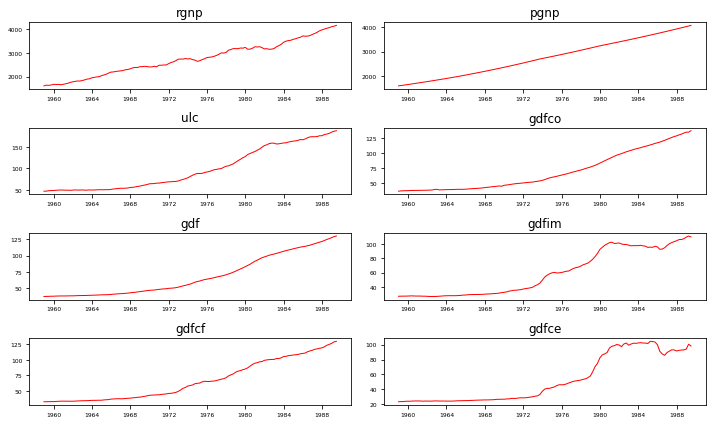

In [75]:
filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.tick_params(labelsize=6)
    
plt.tight_layout()

### Auto Reggression Model

{'test_statistic': 0.6419, 'p_value': 0.9886, 'n_lags': 2, 'n_obs': 120}
P-value:  0.9886
{'test_statistic': -5.4276, 'p_value': 0.0, 'n_lags': 1, 'n_obs': 120}
P-value:  0.0


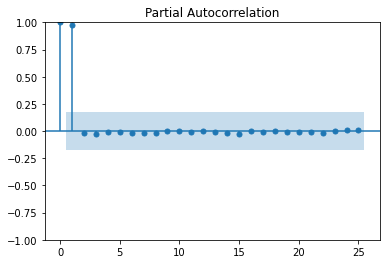

In [76]:
res = adfuller(df['rgnp'], autolag='AIC')

output = {
    'test_statistic': round(res[0], 4),
    'p_value': round(res[1], 4),
    'n_lags': round(res[2], 4),
    'n_obs':res[3]
}

p_value = output['p_value'] 

print(output)
print("P-value: ", p_value)


v = df.rgnp.values
dv = np.diff(v)
r = adfuller(dv, autolag='AIC')
output = {
    'test_statistic': round(r[0], 4),
    'p_value':round(r[1], 4),
    'n_lags':round(r[2], 4),
    'n_obs':r[3]
}
p_value = output['p_value'] 

print(output)
print("P-value: ", p_value)

pacf = plot_pacf(df['rgnp'], lags=25, method='ywm')

### Required Action

* We can observe that the above data is not stationary. Therfore, we need to use the differnce transform (`lag = 1`), according to the `adfuller` test.

In [94]:
df_diff = df.diff().dropna()
df_diff.tail()

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1988-07-01,32.0,23.8,0.9,1.2,1.6,0.1,2.5,0.5
1988-10-01,26.7,23.9,1.7,1.8,1.3,1.1,1.4,0.1
1989-01-01,37.4,24.1,2.8,1.5,1.5,2.2,1.7,1.1
1989-04-01,25.7,24.2,2.0,0.0,1.6,1.6,2.4,6.6
1989-07-01,30.4,24.3,1.3,2.4,0.9,-1.3,0.9,-2.4


{'test_statistic': -5.4276, 'pvalue': 0.0, 'n_lags': 1, 'n_obs': 120}
P-value:  0.0


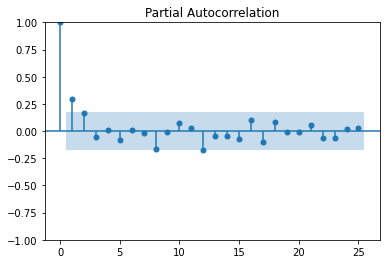

In [95]:
r = adfuller(df_diff['rgnp'], autolag='AIC')

output = {
    'test_statistic': round(r[0], 4),
    'pvalue':round(r[1], 4),
    'n_lags':round(r[2], 4),
    'n_obs':r[3]
}

p_value = output['pvalue'] 
print(output)
print("P-value: ", p_value)

pacf = plot_pacf(df_diff['rgnp'], lags=25, method='ywm')



<AxesSubplot:xlabel='date'>

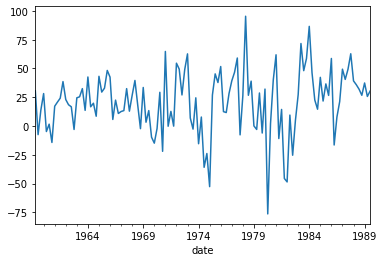

In [96]:
df_diff['rgnp'].plot()

* Now it is easy to see that data is stationary, and the AR model can be applied.

### Fitting a AutoRegression Model

In [97]:
### split the data to train and test

train_data = np.asarray(df_diff['rgnp'][:len(df_diff)-10])
test_data = np.asarray(df_diff['rgnp'][len(df_diff)-10:])

### Train

In [98]:
lags=2

model = AutoReg(train_data, lags=lags)
model_fit = model.fit()
coef = model_fit.params

print(f'Coefficients: {coef}')

Coefficients: [12.32232121  0.2303992   0.14956776]


### Evaluate

predicted=26.874, expected=40.5
predicted=29.042, expected=49.300
predicted=29.738, expected=62.799
predicted=34.165, expected=39.200
predicted=30.746, expected=35.899
predicted=26.456, expected=32.0
predicted=25.064, expected=26.700
predicted=23.260, expected=37.400
predicted=24.932, expected=25.699
predicted=23.837, expected=30.399
Test RMSE: 14.206


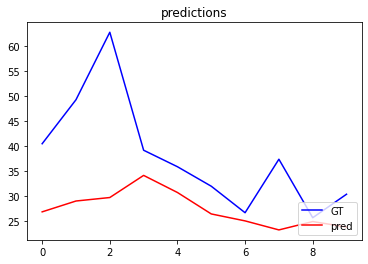

In [99]:
#test model on test data
history = [p for p in train_data[len(train_data)-lags:]]#saving the history from trainig data fr future predictions
predictions = []

for t in range(len(test_data)):
    length = len(history)
    lag = [history[i] for i in range(length-lags,length)]
    yhat = coef[0]
    for d in range(lags):
        yhat += coef[d+1] * lag[lags-d-1]
    obs = test_data[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted={}, expected={}'.format(str(yhat)[:6], str(obs)[:6]))
    
rmse = sqrt(mean_squared_error(test_data, predictions))
print('Test RMSE: %.3f' % rmse)

plt.plot(test_data, color='blue')
plt.plot(predictions, color='red')
plt.legend(["GT", "pred"], loc ="lower right")
plt.title('predictions')
plt.show()

In [100]:
test = 'ssr_chi2test'

n_col = len(df.columns)
for i in range(n_col):
    for j in range(n_col):
        if i != j:
            test_result = grangercausalitytests(
                df[[df.columns[i], df.columns[j]]],
                maxlag=10,
                verbose=False
                )
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(10)]
            min_p_value = np.min(p_values)
            print(f"{df.columns[i]} <> {df.columns[j]}: {str(min_p_value)} {str(min_p_value < 0.05)}")

rgnp <> pgnp: 0.0106 True
rgnp <> ulc: 0.0001 True
rgnp <> gdfco: 0.0212 True
rgnp <> gdf: 0.0027 True
rgnp <> gdfim: 0.0668 False
rgnp <> gdfcf: 0.0001 True
rgnp <> gdfce: 0.0071 True
pgnp <> rgnp: 0.0 True
pgnp <> ulc: 0.0 True
pgnp <> gdfco: 0.0 True
pgnp <> gdf: 0.0 True
pgnp <> gdfim: 0.0 True
pgnp <> gdfcf: 0.0 True
pgnp <> gdfce: 0.0 True
ulc <> rgnp: 0.0 True
ulc <> pgnp: 0.0 True
ulc <> gdfco: 0.0002 True
ulc <> gdf: 0.0 True
ulc <> gdfim: 0.0 True
ulc <> gdfcf: 0.0 True
ulc <> gdfce: 0.0041 True
gdfco <> rgnp: 0.0 True
gdfco <> pgnp: 0.0 True
gdfco <> ulc: 0.0 True
gdfco <> gdf: 0.0 True
gdfco <> gdfim: 0.0 True
gdfco <> gdfcf: 0.0 True
gdfco <> gdfce: 0.0 True
gdf <> rgnp: 0.0 True
gdf <> pgnp: 0.0 True
gdf <> ulc: 0.0 True
gdf <> gdfco: 0.0 True
gdf <> gdfim: 0.0 True
gdf <> gdfcf: 0.0 True
gdf <> gdfce: 0.0 True
gdfim <> rgnp: 0.0011 True
gdfim <> pgnp: 0.0067 True
gdfim <> ulc: 0.0014 True
gdfim <> gdfco: 0.0083 True
gdfim <> gdf: 0.0011 True
gdfim <> gdfcf: 0.001 True
gd

In [101]:
print('adfuller test for the data')
for col_name in df.columns:
    print(col_name)
    r = adfuller(df[col_name], autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    print(output)
    print("P-value: ", p_value)
    
##not stationary
    
print()
print('adfuller test for the diff data')
for col_name in df_diff.columns:
    print(col_name)
    r = adfuller(df_diff[col_name], autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    print(output)
    print("P-value: ", p_value)
    
##still not stationary
    
df_diff2 = df_diff.diff().dropna()
print()
print('adfuller test for the diff on the diff data')
for col_name in df_diff2.columns:
    print(col_name)
    r = adfuller(df_diff2[col_name], autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    print(output)
    print("P-value: ", p_value)

##now its good

adfuller test for the data
rgnp
{'test_statistic': 0.6419, 'pvalue': 0.9886, 'n_lags': 2, 'n_obs': 120}
P-value:  0.9886
pgnp
{'test_statistic': 1.2743, 'pvalue': 0.9965, 'n_lags': 1, 'n_obs': 121}
P-value:  0.9965
ulc
{'test_statistic': 1.3967, 'pvalue': 0.9971, 'n_lags': 2, 'n_obs': 120}
P-value:  0.9971
gdfco
{'test_statistic': 0.5762, 'pvalue': 0.987, 'n_lags': 5, 'n_obs': 117}
P-value:  0.987
gdf
{'test_statistic': 1.1129, 'pvalue': 0.9953, 'n_lags': 7, 'n_obs': 115}
P-value:  0.9953
gdfim
{'test_statistic': -0.1987, 'pvalue': 0.9387, 'n_lags': 1, 'n_obs': 121}
P-value:  0.9387
gdfcf
{'test_statistic': 1.6693, 'pvalue': 0.9981, 'n_lags': 9, 'n_obs': 113}
P-value:  0.9981
gdfce
{'test_statistic': -0.8159, 'pvalue': 0.8144, 'n_lags': 13, 'n_obs': 109}
P-value:  0.8144

adfuller test for the diff data
rgnp
{'test_statistic': -5.4276, 'pvalue': 0.0, 'n_lags': 1, 'n_obs': 120}
P-value:  0.0
pgnp
{'test_statistic': -1.759, 'pvalue': 0.401, 'n_lags': 0, 'n_obs': 121}
P-value:  0.401
ulc


### VAR Model

In [102]:
df_train = df_diff2[0:-10]
df_test = df_diff2[-10:]
print(f"Dimensions:\nTrain: {df_train.shape}\nTest: {df_test.shape}")

Dimensions:
Train: (111, 8)
Test: (10, 8)


In [105]:
model = VAR(df_train)
x = model.select_order(maxlags=10)
x.summary()

model_fitted = model.fit(3)
model_fitted.summary()

/Users/dor.polovincik/db/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 25, Dec, 2021
Time:                     18:20:58
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    2.88232
Nobs:                     108.000    HQIC:                -0.0706914
Log likelihood:          -913.395    FPE:                   0.133157
AIC:                     -2.08459    Det(Omega_mle):       0.0251733
--------------------------------------------------------------------
Results for equation rgnp
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            2.226251         2.655675            0.838           0.402
L1.rgnp         -0.771244         0.140779           -5.478           0.000
L1.pgnp          1.229664         4.966003            0.248           0.804
L1.ul

In [106]:
lag = model_fitted.k_ar

history = df_diff2.values[-lag:]

fc = model_fitted.forecast(y=history, steps=10)
df_forecast = pd.DataFrame(fc, index=df.index[-10:], columns=df.columns + '_pred')
df_forecast

,rgnp_pred,pgnp_pred,ulc_pred,gdfco_pred,gdf_pred,gdfim_pred,gdfcf_pred,gdfce_pred
date,,,,,,,,
1987-04-01,17.376132,0.484916,-0.222639,-0.964428,0.589576,-0.394204,1.235903,1.018233
1987-07-01,31.396117,0.394146,-0.524935,-0.667643,-0.548806,2.314554,-0.084304,2.404565
1987-10-01,-55.167026,-0.141369,0.724899,0.147073,-0.065259,-1.648670,-0.789028,-2.169385
1988-01-01,58.513425,0.567602,0.100749,0.563663,0.239273,0.008605,0.551512,0.760535
1988-04-01,-43.900284,-0.081924,0.328657,-0.325049,0.090633,1.134821,0.293410,0.276895
1988-07-01,22.387302,0.549101,-0.604415,-0.023653,-0.214851,-0.018321,-0.346749,-0.253241
1988-10-01,-28.466768,-0.307845,0.334815,0.093750,0.110313,-0.570528,-0.105428,0.042867
1989-01-01,21.803147,-0.099894,0.036740,0.124601,0.045485,0.477885,0.479508,0.619495
1989-04-01,-7.361517,0.101500,0.018547,-0.096870,-0.001966,0.189919,-0.218470,-0.629995


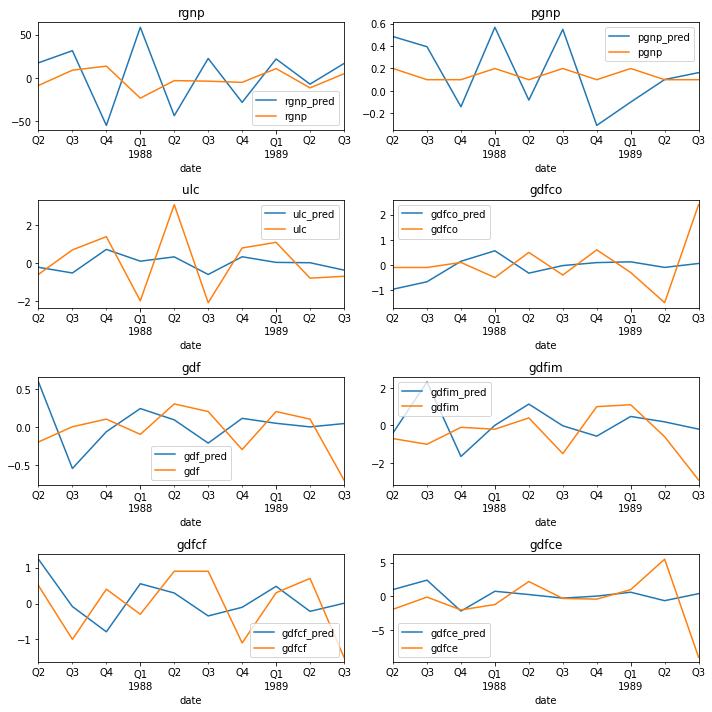

In [107]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_forecast[col+'_pred'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col)

plt.tight_layout();

In [108]:
for col_name in df_diff2.columns:
    print(col_name)
    rmse = sqrt(mean_squared_error(df_test[col_name][-10:], df_forecast[col_name+'_pred']))
    print('Test RMSE: %.3f' % rmse)

rgnp
Test RMSE: 39.772
pgnp
Test RMSE: 0.279
ulc
Test RMSE: 1.362
gdfco
Test RMSE: 1.044
gdf
Test RMSE: 0.451
gdfim
Test RMSE: 1.645
gdfcf
Test RMSE: 0.979
gdfce
Test RMSE: 3.857


In [109]:
df_diff

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-04-01,30.6,13.9,0.0,0.5,0.1,0.1,-0.1,0.3
1959-07-01,-7.5,14.0,1.2,0.2,0.1,0.1,0.2,0.0
1959-10-01,13.9,14.1,0.1,0.1,0.2,0.0,0.1,0.4
1960-01-01,28.2,14.3,0.3,0.1,0.0,0.1,-0.1,0.0
1960-04-01,-4.8,14.4,0.5,0.2,0.2,0.2,0.4,0.1
...,...,...,...,...,...,...,...,...
1988-07-01,32.0,23.8,0.9,1.2,1.6,0.1,2.5,0.5
1988-10-01,26.7,23.9,1.7,1.8,1.3,1.1,1.4,0.1
1989-01-01,37.4,24.1,2.8,1.5,1.5,2.2,1.7,1.1


### LSTM

In [120]:
window=2
BATCH_SIZE=1

def create_data_for_lstm(data, window):
    N = len(data)
    X = [np.asarray(data[i:(i + window)]).reshape((window, 1)) for i in range(N-window)]
    Y = [data[i + window] for i in range(N-window)]
    return np.asarray(X), np.asarray(Y)

X, Y = create_data_for_lstm(np.asarray(df_diff['rgnp']),window)

len_data = len(X)
len_training_Set = int(0.9*len_data)

X_train_val, Y_train_val = X[:len_training_Set], Y[:len_training_Set]
X_test, Y_test = X[len_training_Set:], Y[len_training_Set:]

data = list(zip(X_train_val ,Y_train_val))
random.shuffle(data)
X_train_val, Y_train_val = zip(*data)

X_train_val=np.asarray(list(X_train_val))
Y_train_val=np.asarray(list(Y_train_val))

X_train = X_train_val[:int(0.8*len(X))]
Y_train = Y_train_val[:int(0.8*len(X))]
X_val = X_train_val[int(0.8*len(X)):]
Y_val = Y_train_val[int(0.8*len(X)):]

print("Set Dimensions: (X, Y)")
print(f"Training Set: {X_train.shape}, {Y_train.shape}")
print(f"Validation Set: {X_val.shape}, {Y_val.shape}")
print(f"Test Set: {X_test.shape}, {Y_test.shape}")

Set Dimensions: (X, Y)
Training Set: (96, 2, 1), (96,)
Validation Set: (12, 2, 1), (12,)
Test Set: (12, 2, 1), (12,)


### Torch Data Preperation

In [121]:
train_dataset = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(Y_train).float()
    )

val_dataset = TensorDataset(
    torch.from_numpy(X_val).float(),
    torch.from_numpy(Y_val).float()
    )

test_dataset = TensorDataset(
    torch.from_numpy(X_test).float(),
    torch.from_numpy(Y_test).float()
    )


train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True)

datatloaders = {
    'train': train_dataloader,
    'val': val_dataloader,
    'test': test_dataloader
}

In [125]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0, c0))
        output = out[:, -1, :]
        output = self.fc(output)
        return output
    
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
NUM_EPOCHS=2000


input_dim = 1
hidden_dims = [2, 4, 8, 16, 32]
layer_dim = 2
output_dim = 1
history_rgnp = {}

for hid_dim in hidden_dims:
    lstm_model = LSTMModel(input_dim,hid_dim,layer_dim,output_dim)
    
    print('\nHidden dim size: ', hid_dim)
    print(f'Number of parameters for LSTM model: {str(count_parameters(lstm_model))}'

    criterion = nn.MSELoss()
    optimizer = optim.Adam(lstm_model.parameters())

    best_val_loss=100000000.0
    best_lstm_model=copy.deepcopy(lstm_model)
    dest_path_best_model='LSTM_best_model_hd_'+str(hid_dim)+'.pth'

    history_rgnp[hid_dim]={'train_loss':[],'val_loss':[]}

    num_batches=len(train_dataloader)
    for epoch in range(NUM_EPOCHS):  
        
        for phase in ['train','val']:
            if phase=='train':
                lstm_model.train()
            else:
                lstm_model.eval()
            running_loss = 0.0
            running_acc = 0.0
            samples=0
            for i, data_btch in enumerate(datatloaders[phase]):
                inputs, labels = data_btch
                optimizer.zero_grad()
                outputs = lstm_model(inputs)
                loss = criterion(outputs, labels)

                if phase=='train':
                    loss.backward()
                    optimizer.step()

                samples += labels.size(0)
                running_loss += loss.item()*labels.size(0)
            epoch_loss = float(running_loss)/samples
            history_rgnp[hid_dim][phase+'_loss'].append(epoch_loss)
            
            if epoch%100 == 0:
                print(f"Epoch {str(epoch)}:  {phase} loss: {str(epoch_loss)[:6]}")
                
            if phase == 'val':
                if epoch_loss<best_val_loss:
                    best_cnn_val_acc = epoch_loss
                    best_cnn_model = copy.deepcopy(lstm_model)
                    torch.save(lstm_model,dest_path_best_model)
                


Hidden dim size:  2
Number of parameters for LSTM model: 91


/Users/dor.polovincik/db/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0:  train loss: 1182.8
Epoch 0:  val loss: 914.20
Epoch 100:  train loss: 829.92
Epoch 100:  val loss: 556.48
Epoch 200:  train loss: 735.69
Epoch 200:  val loss: 526.18
Epoch 300:  train loss: 700.81
Epoch 300:  val loss: 509.16
Epoch 400:  train loss: 670.44
Epoch 400:  val loss: 489.90
Epoch 500:  train loss: 655.31
Epoch 500:  val loss: 488.74
Epoch 600:  train loss: 646.49
Epoch 600:  val loss: 491.12
Epoch 700:  train loss: 640.67
Epoch 700:  val loss: 491.61
Epoch 800:  train loss: 637.21
Epoch 800:  val loss: 494.75
Epoch 900:  train loss: 634.45
Epoch 900:  val loss: 496.35
Epoch 1000:  train loss: 631.50
Epoch 1000:  val loss: 490.46
Epoch 1100:  train loss: 628.89
Epoch 1100:  val loss: 492.49
Epoch 1200:  train loss: 627.05
Epoch 1200:  val loss: 499.06
Epoch 1300:  train loss: 623.98
Epoch 1300:  val loss: 509.13
Epoch 1400:  train loss: 618.63
Epoch 1400:  val loss: 532.89
Epoch 1500:  train loss: 609.86
Epoch 1500:  val loss: 552.23
Epoch 1600:  train loss: 604.82


In [ ]:
for hid_size,vals in history_rgnp.items():
    plt.plot(vals['train_loss'],c='red')
    plt.plot(vals['val_loss'],c='blue')
    plt.legend(["train", "validation"], loc ="upper right")
    plt.title(str(hid_size)+' loss')
    plt.show()
 

In [ ]:
for hid_size in hidden_dims:
    model_path='LSTM_best_model_hd_'+str(hid_dim)+'.pth'
    best_lstm_model =torch.load(model_path)
    best_lstm_model.eval()
    predictions=[]
    gt=[]
    with torch.no_grad():
        for i, data_btch in enumerate(datatloaders['test']):
                inputs, labels = data_btch
                outputs = best_lstm_model(inputs)
                for i,out in enumerate(outputs):
                    predictions.append(out)
                    gt.append(labels[i])
    plt.plot(predictions,c='red')
    plt.plot(gt,c='blue')
    plt.legend(["pred", "gt"], loc ="upper right")
    plt.title(str(hid_size)+' predictions')
    plt.show()
            